In [1]:
#导包以及预定义参数
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn

directory = r"total_data"
directory_newdata = r"clean_data"
file_name = os.listdir(directory)

target_y = []
target_x = []
landing_threshold = 1.6
seccend_level_landing_threshold = 1.9
columns_to_extract = [5, 8, 11, 12, 13, 14, 15, 16, 19, 26, 28, 30, 32, 33, 34, 35, 36, 37, 41, 42, 43, 44, 45]
column_names = ['FLIGHT PHASE', 'DIST TO PSEUDO THRESHOLD', 'COMPUTED AIRSPEED', 'VERTICAL SPEED',
                'VERTICAL ACCELERATION ACQ', 'CAP DISP HEADING', 'LOCALIZER DEV IN DOTS',
                'GLIDE DEVIATION IN DOTS', 'FLIGHT PATH ANGLE', 'RADIO ALTITUDE', 'PITCH ANGLE',
                'ROLL ANGLE', 'N11', 'N22', 'SELTD N1 INDICATED 1', 'SELTD N1 INDICATED 2',
                'WIND SPEED', 'WIND DIRECTION', 'CONTROL COLUMN POSITION',
                'CONTROL WHEEL POSITION', 'RUDDER PEDAL', 'THROTTLE ANGLE1', 'THROTTLE ANGLE2',]

原数据数据结构

- 00    05      FLIGHT PHASE                (飞行阶段)
- 01    08      DIST TO PSEUDO THRESHOLD    (到伪跑到头的距离)
- 02    11      COMPUTED AIRSPEED           (空速)
- 03    12      VERTICAL SPEED              (垂直速度)
- 04    13      VERTICAL ACCELERATION ACQ   (垂直加速度)
- 05    14      CAP DISP HEADING            (航向)
- 06    15      LOCALIZER DEV IN DOTS       (航向道偏差)
- 07    16      GLIDE DEVIATION IN DOTS     (下滑道偏差)
- 08    19      FLIGHT PATH ANGLE           (飞行路径角)
- 09    26      RADIO ALTITUDE              (无线电高度)
- 10    28      PITCH ANGLE                 (俯仰角)
- 11    30      ROLL ANGLE                  (滚转角)
- 12    32      N11                         (发动机N1转速百分比)
- 13    33      N22                         (发动机N2转速百分比)
- 14    34      SELTD N1 INDICATED 1        ()
- 15    35      SELTD N1 INDICATED 2        ()
- 16    36      WIND SPEED                  (风速)
- 17    37      WIND DIRECTION              (风向)
- 18    41      CONTROL COLUMN POSITION     (控制杆位置)
- 19    42      CONTROL WHEEL POSITION      (控制轮位置)
- 20    43      RUDDER PEDAL                (方向舵踏板位置)
- 21    44      THROTTLE ANGLE1             (油门角度1)
- 22    45      THROTTLE ANGLE2             (油门角度2)

In [2]:
#数据预处理
#按照飞机垂直高度作为参考指标
#以飞机垂直高度=0作为接地点
#数据选取1000英尺——接地点之间以10英尺为切片的数据 + 接地点后10s的数据作为输入数据
for f in file_name:
    file = os.path.join(directory, f)#连接文件路径
    df = pd.read_csv(file, skiprows=[0, 1, 3, 4], header=0)#读文件
    
    # #将一次航班最大垂直加速度记录到target_y中
    # is_heavy_landing = False
    # max_g = 0.0
    # for i in df.iloc[:, 13]:
    #     if max_g < i:
    #         max_g = i
    # target_y.append(max_g)

    #选取所需的特征
    df = df.iloc[:,columns_to_extract]
    df.columns = column_names
    # print(df.dtypes)
    
    #数据选取1000英尺——接地点之间的数据 + 接地点后10s的数据作为输入数据
    above = df[df['RADIO ALTITUDE'] >= 1000].iloc[-1]
    temp = df[df['RADIO ALTITUDE'] == 0]
    below = temp[temp['FLIGHT PHASE'] == 11].iloc[0]
    df_filtered1 = df.loc[above.name: below.name]
    df_filtered2 = df.loc[below.name+1: below.name+10]


    #按照无线电垂直高度10英尺为切片，运用线性插值法进行插值
    num = int(1000/10)+1
    distances = np.linspace(1000, 0, num)
    interpolated_data = pd.DataFrame(columns=column_names)
    for i in column_names:
        if i == 'RADIO ALTITUDE': #无线电高度这一列直接
            interpolated_data[i] = distances
        else:
            interpolated_data[i] = np.interp(
            distances * -1,#distances 和 df_filtered.iloc[:,1]都乘以-1是因为interp函数只接收递增数组作为索引
            df_filtered1['RADIO ALTITUDE'] * -1,
            df_filtered1[i],
        )
    
    #选择训练所使用的特征
    selected_column_names = ['DIST TO PSEUDO THRESHOLD', 'COMPUTED AIRSPEED', 'VERTICAL SPEED', 'CAP DISP HEADING', 'LOCALIZER DEV IN DOTS',
                             'GLIDE DEVIATION IN DOTS', 'FLIGHT PATH ANGLE', 'RADIO ALTITUDE', 'PITCH ANGLE','ROLL ANGLE', 'N11', 'N22',
                             'SELTD N1 INDICATED 1', 'SELTD N1 INDICATED 2','WIND SPEED', 'WIND DIRECTION', 'CONTROL COLUMN POSITION',
                             'CONTROL WHEEL POSITION', 'RUDDER PEDAL', 'THROTTLE ANGLE1', 'THROTTLE ANGLE2',]
    interpolated_data = interpolated_data[selected_column_names]
    interpolated_data.reset_index(drop=True, inplace=True)
    # np_data = interpolated_data.to_numpy()
    # np_data = np_data.astype(np.float32)
    # torch_data = torch.tensor(np_data)
    # target_x.append(torch_data)
    
    #构造路径，储存处理后的数据
    file_for_write = os.path.join(directory_newdata, f)
    interpolated_data.to_csv(file_for_write, index=False)

# #储存标签统计得到的数据
# target_y_df = pd.DataFrame(target_y, columns=['Values'])
# print(len(target_y))
# print(target_y_df.shape)
# target_y_df.to_csv(r"target_y\\target_y.csv")

C:\Users\97449\AppData\Local\Temp\ipykernel_8188\3404666230.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, skiprows=[0, 1, 3, 4], header=0)#读文件
C:\Users\97449\AppData\Local\Temp\ipykernel_8188\3404666230.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, skiprows=[0, 1, 3, 4], header=0)#读文件
C:\Users\97449\AppData\Local\Temp\ipykernel_8188\3404666230.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, skiprows=[0, 1, 3, 4], header=0)#读文件
C:\Users\97449\AppData\Local\Temp\ipykernel_8188\3404666230.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, skiprows=[0, 1, 3, 4], header=0)#读文件
C:\Users\97449\AppData\Local\Temp\ipykernel_8188\3404666230.py:7: DtypeWarning: Columns 

最终选择的21个特征

- 01    08      DIST TO PSEUDO THRESHOLD    (到伪跑到头的距离)
- 02    11      COMPUTED AIRSPEED           (空速)
- 03    12      VERTICAL SPEED              (垂直速度)
- 04    14      CAP DISP HEADING            (航向)
- 05    15      LOCALIZER DEV IN DOTS       (航向道偏差)
- 06    16      GLIDE DEVIATION IN DOTS     (下滑道偏差)
- 07    19      FLIGHT PATH ANGLE           (飞行路径角)
- 08    26      RADIO ALTITUDE              (无线电高度)
- 09    28      PITCH ANGLE                 (俯仰角)
- 10    30      ROLL ANGLE                  (滚转角)
- 11    32      N11                         (发动机N1转速百分比)
- 12    33      N22                         (发动机N2转速百分比)
- 13    34      SELTD N1 INDICATED 1        ()
- 14    35      SELTD N1 INDICATED 2        ()
- 15    36      WIND SPEED                  (风速)
- 16    37      WIND DIRECTION              (风向)
- 17    41      CONTROL COLUMN POSITION     (控制杆位置)
- 18    42      CONTROL WHEEL POSITION      (控制轮位置)
- 19    43      RUDDER PEDAL                (方向舵踏板位置)
- 20    44      THROTTLE ANGLE1             (油门角度1)
- 21    45      THROTTLE ANGLE2             (油门角度2)

# 此处往上是数据处理部分

# 训练所使用的数据

<ul>数据探索性分析：
    <li>1.数据汇总处理
    <li>2.缺失值分析
    <li>3.异常值分析
    <li>4.数据特征分析
    <li>5.类别特征分析
</ul>

<ul>
    <li>斯皮尔曼相关系数分析数据SMOTE合成少数过采样技术
    <li>SHAP可解释性分析
    <li>逻辑回归/聚类方法进行阈值的确定
</ul>

In [2]:
#定义模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size = [40,30,20]):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layer = 1
        self.output_size = 1

        # # Batch Normalization层
        # self.bn = nn.BatchNorm1d(input_size)
        # Three Layter LSTM
        self.lstm1 = nn.LSTM(input_size, hidden_size[0])
        self.lstm2 = nn.LSTM(hidden_size[0], hidden_size[1])
        self.lstm3 = nn.LSTM(hidden_size[1], hidden_size[2])
        # Full collected
        self.fc = nn.Linear(hidden_size[2], self.output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # LSTM 前向传播
        # x = x.permute(0, 2, 1)  
        # x = self.bn(x)
        # x = x.permute(0, 2, 1)  
        out1, _ = self.lstm1(x)
        out2, _ = self.lstm2(out1)
        out3, _ = self.lstm3(out2)

        # 取最后一个时间步的输出
        out = self.fc(out3[:, -1, :])
        # return self.sigmoid(out)
        return out

In [3]:
#获取数据
import torch.optim as optim
import torch.utils.data as data_utils

X = []
y = []

file_clean_data = os.listdir(directory_newdata)
for f in file_clean_data:
    #合成数据文件路径
    file2 = os.path.join(directory_newdata, f)
    #读取数据
    df = pd.read_csv(file2)
    #将数据从dataframe格式转换为torch支持的tensor结构
    np_x = df.to_numpy()
    np_x = np_x.astype(np.float32)
    torch_x = torch.tensor(np_x)
    X.append(torch_x)

y = pd.read_csv(r"target_y/target_y.csv")

print("数据总量X:",len(X))
print("X中数据的各维度大小",X[0].shape)
print("标签y长度:",len(y))

数据总量X: 2895
X中数据的各维度大小 torch.Size([101, 21])
标签y长度: 2895


In [4]:
#打乱数据 //暂时被替代，不使用
m = torch.randperm(len(X))
train_size = int(len(X)* 2/3)
m_train = m[0:train_size]
print(len(m_train))
m_test = m[train_size:]
print(len(m_test))
X_train = []
y_train = []
X_test = []
y_test = []
y = y.to_numpy()
y = y.astype(np.float32)
y = torch.tensor(y)
for i in m_train:
    X_train.append(X[i])
    y_train.append(y[i])
for j in m_test:
    X_test.append(X[j])
    y_test.append(y[j])
print("------------")
print("训练集上的数据X_train数量:",len(X_train))
print("测试集上的数据X_test数量:",len(X_test))
print("训练集上的标签y_train数量:",len(y_train))
print("测试集上的标签y_test数量:",len(y_test))

1930
965
------------
训练集上的数据X_train数量: 1930
测试集上的数据X_test数量: 965
训练集上的标签y_train数量: 1930
测试集上的标签y_test数量: 965


In [4]:
#使用batchnorm归一化X
stacked_X = torch.stack(X)#将X从list类型转为tensor

#对数据集使用层归一化
print("shape of stacked_x:", stacked_X.shape)
stacked_X = stacked_X.permute(0,2,1)
print("shape of changed X:", stacked_X.shape)
print("size of feachers:", stacked_X.size(1))
batchnorm = nn.BatchNorm1d(stacked_X.size(1))
temp_normed_X = batchnorm(stacked_X)
normed_X = temp_normed_X.permute(0,2,1)
print("shape of normed X:", normed_X.shape)

normed_X = normed_X.detach()#清除梯度 消除grad_fn参数

shape of stacked_x: torch.Size([2895, 101, 21])
shape of changed X: torch.Size([2895, 21, 101])
size of feachers: 21
shape of normed X: torch.Size([2895, 101, 21])


In [5]:
#处理y，将y从dataframe格式转换为tensor格式
y1 = y.iloc[:,1]
np_y = y1.to_numpy()
np_y = np_y.astype(np.float32)
tensor_y = torch.tensor(np_y)

In [6]:
#划分训练集和测试集
dataset = data_utils.TensorDataset(normed_X, tensor_y)

train_size = int(len(dataset)*2/3)
test_size = len(dataset) - train_size

train_dataset, test_dataset = data_utils.random_split(
    dataset,
    [train_size, test_size]
)
print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")

#创建训练集和测试集的dataloader
train_dataloader = data_utils.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = data_utils.DataLoader(test_dataset, batch_size=1, shuffle=True)


训练集大小: 1930
测试集大小: 965


In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # 使用GPU
else:
    device = torch.device("cpu")   # 使用CPU
print(device)


cpu


In [8]:
#模型参数设置
learning_rate = 0.01
epoch = 400
sequence_length = stacked_X.size(0)
input_size = stacked_X.size(1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model = LSTMModel(input_size= input_size).to(device)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



In [9]:
for inputs, label in train_dataloader:
    print(type(inputs))
    print(inputs.shape)

<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 101, 21])
<class 'torch.Tensor'>
torch.Size([1, 10

In [11]:
#模型训练
model.train()
for i in range(epoch):
    total_loss = 0.0
    for inputs, label in train_dataloader:

        no_grad_inputs = inputs.detach()#再次消除输出中的grad_fn参数 防止意外

        #使用gpu加速
        gpu_inputs = no_grad_inputs.to(device)
        gpu_label = label.to(device)
        
        outputs = model(gpu_inputs).squeeze(-1)#模型输出
        loss = criterion(outputs,gpu_label)#计算损失
        optimizer.zero_grad()#清零梯度
        loss.backward()#反向传播
        optimizer.step()#更新参数

        total_loss += loss.item()#统计损失
    if (i + 1) % 25 == 0:
        print(f'Epoch [{i + 1}/{epoch}], Loss: {total_loss / len(train_dataset):.4f}')#打印训练过程中的损失

Epoch [25/400], Loss: 0.0179


KeyboardInterrupt: 

In [11]:
#模型测试评估
model.eval()
eval_loss = 0
with torch.no_grad():
    for inputs, label in test_dataloader:
        outputs = model(inputs.to(device)).squeeze(-1)
        loss = criterion(outputs,label.float().to(device))
        eval_loss += loss.item()
    print(f'eval_loss: {eval_loss / len(test_dataset):.4f}')


eval_loss: 0.0150


In [14]:
#保存模型
torch.save(model, 'full_LSTMModel.pth')

In [14]:
#读取模型
model = torch.load('full_LSTMModel.pth',weights_only=False).to(device)

In [15]:
model.eval()

LSTMModel(
  (lstm1): LSTM(20, 40)
  (lstm2): LSTM(40, 30)
  (lstm3): LSTM(30, 20)
  (fc): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [16]:
device

device(type='cuda', index=0)

In [17]:
#准备背景数据集
background_indices = np.random.choice(len(train_dataset), 100, replace=False)
background_data = []
for idx in background_indices:
    # 获取样本 - 假设train_dataset返回(input, target)元组
    sample = train_dataset[idx][0]  # 只取输入数据，忽略标签
    background_data.append(sample)
background_data = torch.stack(background_data).to(device)
print(f"背景数据形状: {background_data.shape}") 

背景数据形状: torch.Size([100, 101, 20])


In [23]:
import shap

explainer = shap.GradientExplainer(
    model, 
    background_data,
    batch_size=16  # 减小批次大小
)

# 获取要解释的样本（少量样本）
sample_indices = [0, 1, 2]  # 只取3个样本以减少计算量
sample_to_explain = torch.stack([train_dataset[i][0] for i in sample_indices]).to(device)

In [24]:
with torch.enable_grad():  # 启用梯度计算
    model.train()  # 切换到训练模式
    # 计算 SHAP 值
    shap_values = explainer.shap_values(sample_to_explain)
# 切换回评估模式
model.eval()

LSTMModel(
  (lstm1): LSTM(20, 40)
  (lstm2): LSTM(40, 30)
  (lstm3): LSTM(30, 20)
  (fc): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [42]:
shap_values.shape

(3, 101, 20, 1)

In [52]:
example = shap_values[0]
exa = example.squeeze(2)
e =np.sum(exa, axis=0)
e

array([-3.34650405e-05,  9.21850718e-03, -3.29209658e-03,  2.46678413e-02,
        2.77849528e-04, -3.37526216e-03,  0.00000000e+00, -1.09409800e-01,
        4.92894517e-03,  4.63806899e-04, -3.10635978e-05,  4.97281348e-04,
       -1.62803299e-05,  8.29204267e-03, -3.09707420e-02, -1.70675898e-02,
       -1.63178267e-04,  1.06411073e-02,  9.01188664e-04,  1.68806455e-03])

C:\Users\Szoke\AppData\Local\Temp\ipykernel_28956\1473650220.py:18: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Szoke\AppData\Local\Temp\ipykernel_28956\1473650220.py:18: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Szoke\AppData\Local\Temp\ipykernel_28956\1473650220.py:18: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Szoke\AppData\Local\Temp\ipykernel_28956\1473650220.py:18: UserWarning: Glyph 32500 (\N{CJK UNIFIED IDEOGRAPH-7EF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Szoke\AppData\Local\Temp\ipykernel_28956\1473650220.py:18: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Szoke\AppData\Local\Temp\ipykernel_28956\1473650220.py:18: UserWarning: Glyph 25955 (\

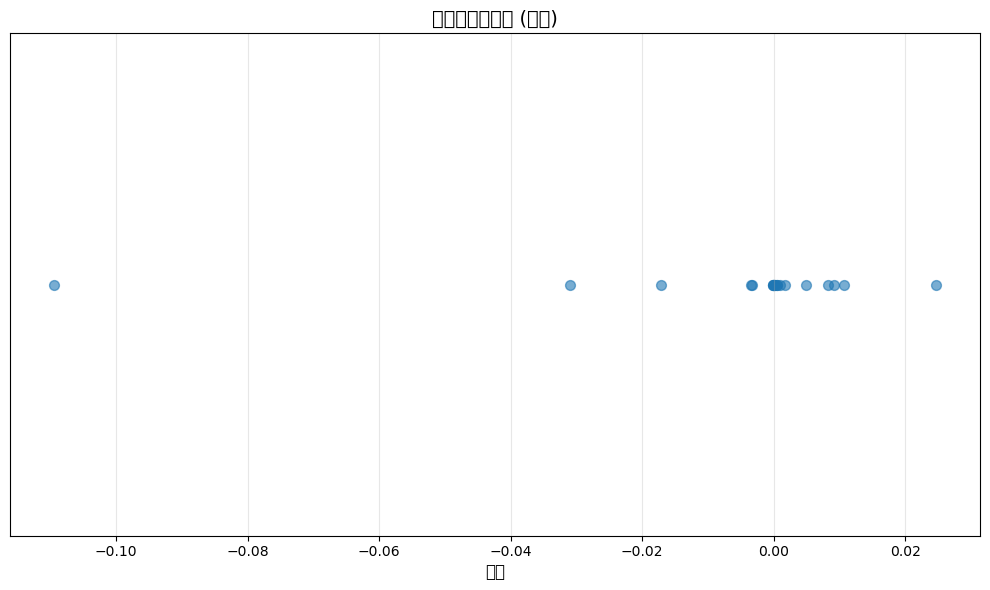

In [53]:
import matplotlib.pyplot as plt

# 创建图表
plt.figure(figsize=(10, 6))

# 绘制散点图 - 所有点在同一水平线上
plt.scatter(e, np.zeros_like(e), alpha=0.6, s=50)

# 添加标题和标签
plt.title("一维数据散点图 (基本)", fontsize=14)
plt.xlabel("数值", fontsize=12)
plt.yticks([])  # 隐藏y轴刻度

# 添加网格线
plt.grid(axis='x', alpha=0.3)

# 显示图表
plt.tight_layout()
plt.savefig("basic_1d_scatter.png", dpi=300)
plt.show()

C:\Users\Szoke\AppData\Local\Temp\ipykernel_28956\1481318368.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[0].squeeze(2), sample_to_explain[0], plot_type="bar")


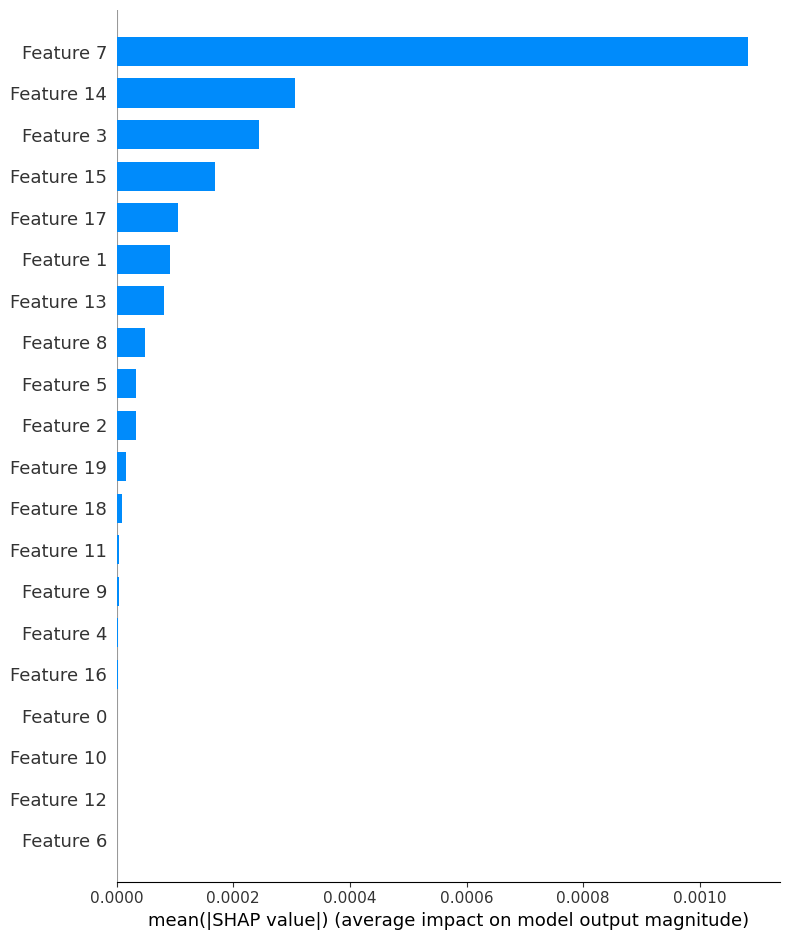

In [56]:
shap.summary_plot(shap_values[0].squeeze(2), sample_to_explain[0], plot_type="bar")

In [ ]:
8     28      PITCH ANGLE                 (俯仰角)
15    37      WIND DIRECTION              (风向)
3     12      VERTICAL SPEED              (垂直速度)

In [41]:
#单样本热力图
import matplotlib.pyplot as plt

# 选择第一个样本
sample_idx = 0
shap_values_sample = np.squeeze(shap_values[sample_idx])  # 形状 (101, 20)


if isinstance(sample_to_explain, torch.Tensor):
    input_data_sample = sample_to_explain[sample_idx].cpu().numpy()  # 形状 (101, 20)
else:
    input_data_sample = sample_to_explain[sample_idx]  # 假设已经是 NumPy

feature_names = [
        'DIST TO PSEUDO THRESHOLD',
        'COMPUTED AIRSPEED',
        'VERTICAL SPEED',
        'LOCALIZER DEV IN DOTS',
        'GLIDE DEVIATION IN DOTS',
        'FLIGHT PATH ANGLE',
        'RADIO ALTITUDE',
        'PITCH ANGLE',
        'ROLL ANGLE',
        'N11',
        'N12',
        'SELTD N1 INDICATED 1',
        'SELTD N1 INDICATED 2',
        'WIND SPEED',
        'WIND DIRECTION',
        'CONTROL COLUMN POSITION',
        'CONTROL WHEEL POSITION',
        'RUDDER PEDAL',
        'THROTTLE ANGLE1',
        'THROTTLE ANGLE2'
]
timesteps = [f"t-{100-i}" for i in range(101)]


# 创建 Explanation 对象
explanation = shap.Explanation(
    values=shap_values_sample,
    data=input_data_sample,                  # 原始输入数据
    feature_names=feature_names              # 特征名称
)


# 创建热力图
plt.figure(figsize=(16, 10))
shap.plots.heatmap(
    explanation,
    instance_order=timesteps,  # 按时间顺序排列
    show=False,                 # 不在内联显示
    max_display=20,             # 显示所有特征
    plot_width=800              # 控制宽度（像素）
)

# 自定义图表
plt.title(f"样本 {sample_idx+1} 的 SHAP 值热力图", fontsize=16, pad=20)
plt.xlabel("特征", fontsize=12)
plt.ylabel("时间步", fontsize=12)

# 添加颜色条说明
cbar = plt.gcf().axes[-1]  # 获取颜色条轴
cbar.set_ylabel("SHAP 值 (对预测的影响)", fontsize=10, labelpad=10)

# 调整布局并保存
plt.tight_layout()
plt.savefig(f"shap_heatmap_sample_{sample_idx+1}.png", dpi=300, bbox_inches="tight")
plt.close()

print(f"已保存热力图: shap_heatmap_sample_{sample_idx+1}.png")


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 1600x1000 with 0 Axes>

In [12]:
#弱分类器 测试集测试
labels = 0
total_test_loss = 0
for _ , label in train_dataloader:
    labels += label
labels_mean = labels / len(train_dataset)

with torch.no_grad():
    for _ , test_label in test_dataloader:
        loss = criterion(test_label, labels_mean)
        total_test_loss += loss
print(f'total_test_loss: {total_test_loss / len(test_dataset):.4f}')

total_test_loss: 0.0181
